In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
# from prophet.forecaster import logger
import matplotlib.pyplot as plt
import importlib.metadata
import logging

prophet_version = importlib.metadata.version('prophet')
print('Prophet %s' % prophet_version)
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.WARNING)


Prophet 1.1.5


In [2]:
# Load the dataset
DATA_PATH = '../data-preprocessing/VinhLong_data.csv'
data = pd.read_csv(DATA_PATH)
data = data[data['Nhiệt độ'] <= 60]
data['Ngày'] = pd.to_datetime(data['Ngày'], format='%d/%m/%Y')
data['Giờ'] = pd.to_datetime(data['Giờ'], format='%H:%M').dt.time
data['Datetime'] = pd.to_datetime(data['Ngày'].astype(str) + ' ' + data['Giờ'].astype(str))
data.set_index('Datetime', inplace=True)
data.drop(['Ngày', 'Giờ'], axis=1, inplace=True)
data.replace(['-', ''], np.nan, inplace=True)
data.dropna(inplace=True)
data = data.apply(pd.to_numeric, errors='ignore')

In [3]:
hourly_data = data.resample('H').mean()
hourly_data.replace(['-', ''], np.nan, inplace=True)
hourly_data.dropna(inplace=True)
hourly_data = hourly_data.apply(pd.to_numeric, errors='ignore')

In [4]:
print(hourly_data.isna().sum())

Nhiệt độ    0
Độ ẩm       0
Khí áp      0
T.độ gió    0
H. gió      0
dtype: int64


In [5]:
# Rename columns and reset index
hourly_data = hourly_data.rename(columns={'Nhiệt độ': 'y'})
hourly_data = hourly_data.reset_index().rename(columns={'Datetime': 'ds'})

In [6]:
train_ratio = 0.80
train_size = int(len(hourly_data) * train_ratio)
train = hourly_data[:train_size]
test = hourly_data[train_size:]

In [7]:
prophet_train = train
prophet_test = test

In [8]:
model = Prophet()
model.add_regressor('Độ ẩm')
model.add_regressor('Khí áp')
model.add_regressor('T.độ gió')
model.add_regressor('H. gió')

In [9]:
# Fit the model
model.fit(prophet_train)

In [10]:
# Create future dataframe
future = model.make_future_dataframe(periods=len(test), freq='H')

In [11]:
hourly_data = hourly_data.reset_index()

future = future.merge(hourly_data[['ds', 'Độ ẩm', 'Khí áp', 'T.độ gió', 'H. gió']], on='ds', how='left')

In [12]:
future.replace(['-', ''], np.nan, inplace=True)
future.dropna(inplace=True)

In [13]:
print(future.isna().sum())

ds          0
Độ ẩm       0
Khí áp      0
T.độ gió    0
H. gió      0
dtype: int64


In [14]:
# Make predictions
forecast = model.predict(future)

Mean Absolute Error: 3.2095375169274667
Root Mean Squared Error: 3.9891140191001764


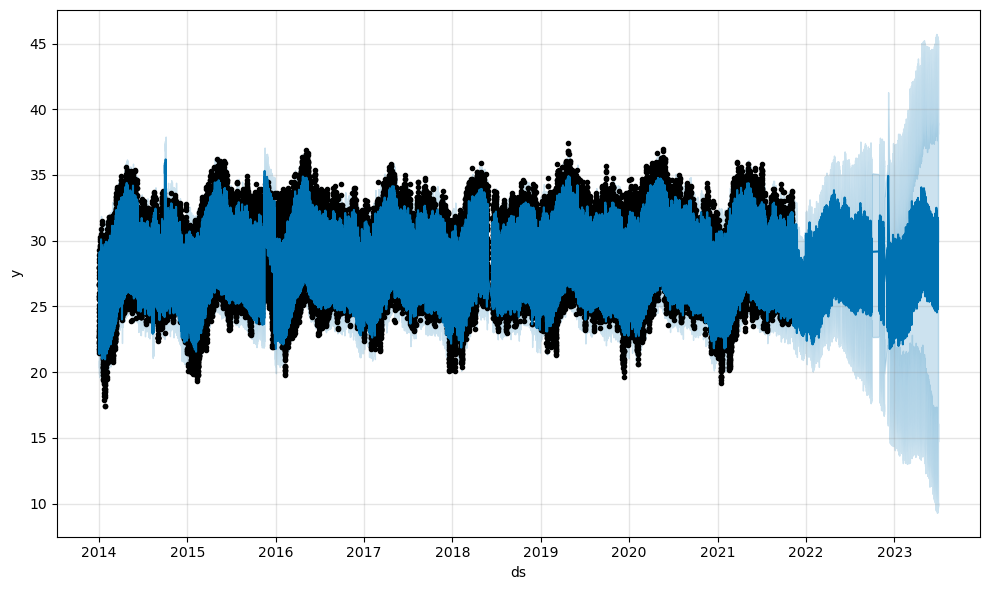

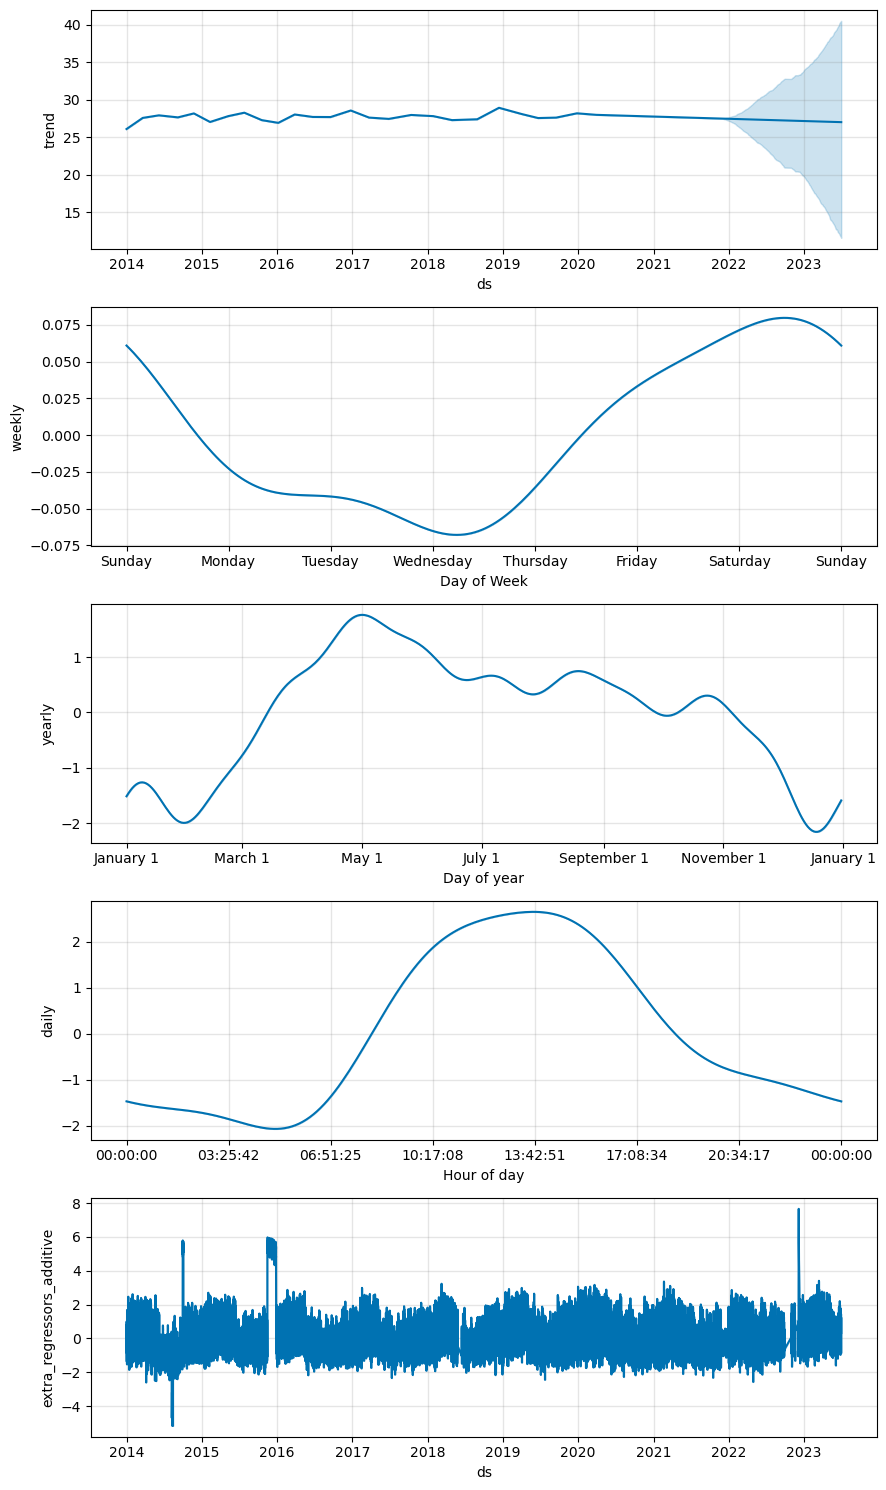

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


y_true = prophet_test['y'].values
y_pred = forecast['yhat'][-len(test):].values
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

# Plot the forecast
fig = model.plot(forecast)
plt.show()

# Plot components
fig2 = model.plot_components(forecast)
plt.show()

In [16]:
from tqdm import tqdm

In [17]:
def rolling_forecast(data, window_size):
    predictions = []
    history = data.iloc[:window_size].copy()
    test = data.iloc[window_size:].copy()
    test.reset_index(drop=True, inplace=True)
    progress = tqdm(range(len(test)))
    
    # prepare model
    
    for i in progress:
        train_roll = history[-window_size:]
        prophet_train = train_roll.rename(columns={'Datetime': 'ds', 'Nhiệt độ': 'y'})
        
        model = Prophet()
        model.add_regressor('Độ ẩm')
        model.add_regressor('Khí áp')
        model.add_regressor('T.độ gió')
        model.add_regressor('H. gió')
        #fit model
        model.fit(prophet_train)        
        
        future = pd.DataFrame(test.iloc[i, :]).T
        future = future.rename({'Datetime': 'ds'})
        
        #make prediction
        forecast = model.predict(future)
        yhat = forecast['yhat'].values
        
        #append
        predictions.append(yhat)
        history = pd.concat([history, test.iloc[[i]]])
        
        # progress.set_description(f'>expected={test.iloc[i]["y"]:.1f}, predicted={yhat[0]:.1f}')
        
    predictions = np.array(predictions).flatten()
    y_true = test['y'].values
    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    
    return rmse, y_true, predictions
    

In [18]:
from sklearn.metrics import mean_squared_error

window_size = 100

rmse, y_true, y_pred = rolling_forecast(hourly_data, window_size)

print(f'RMSE for Temp: {rmse:.3f}')



  0%|          | 0/72163 [00:00<?, ?it/s]

100%|██████████| 72163/72163 [53:46<00:00, 22.37it/s]   


RMSE for Temp: 0.715


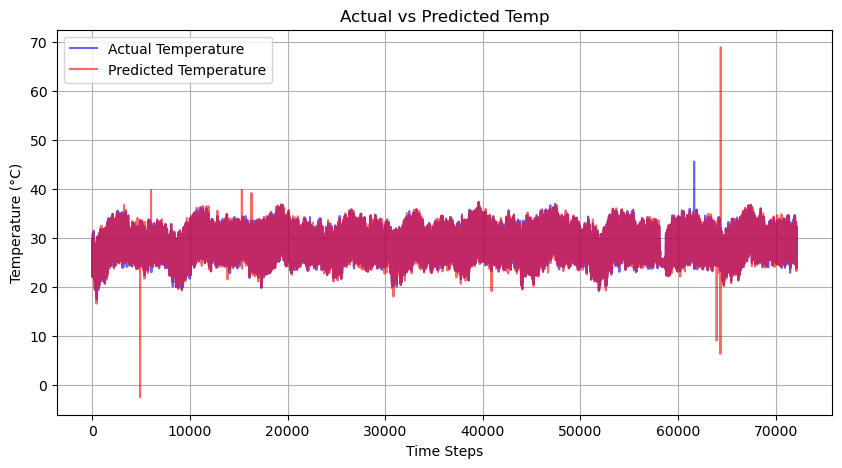

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Actual Temperature', color='blue', alpha=0.6)
plt.plot(y_pred, label='Predicted Temperature', color='red', alpha=0.6)
plt.title('Actual vs Predicted Temp')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()